# Занятие 5: Сегментация

### Практикум на ЭВМ для 317 группы, ВМК МГУ, кафедра ММП

### Варламова Арина, кафедра ММП ВМК МГУ

In [1]:
import utils

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision.transforms import Compose, Normalize

from tqdm.notebook import tqdm

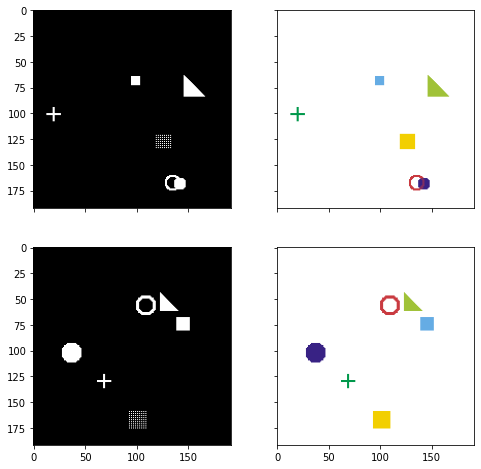

In [2]:
input_images, target_masks = utils.generate_random_data(192, 192, count=2)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]
# Map each channel (i.e. class) to each color
target_masks_rgb = [utils.masks_to_colorimg(x) for x in target_masks]
# Left: Input image (black and white), Right: Target mask (6ch)
utils.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [3]:
input_images, target_masks = utils.generate_random_data(192, 192, count=2)
input_images.shape, target_masks.shape

((2, 192, 192, 3), (2, 6, 192, 192))

In [4]:
input_images.max(), target_masks.max()

(255, 1.0)

## Датасет

In [5]:
class ShapeDataset(Dataset):
    def __init__(self, n_images=2000, 
                 width=224, height=224, transforms=None):
        self.X, self.y = utils.generate_random_data(width=width, 
                                                    height=height, count=n_images)
        self.transform = transforms
    def __getitem__(self, idx):
        image = self.X[idx]
        image = (image / 255).astype('float32')
        image = torch.from_numpy(image).permute(2, 0, 1)
        
        mask = self.y[idx]
        mask = torch.from_numpy(mask)
        if transforms is not None:
            image =self.transform(image)
        return image, mask
    
    def __len__(self):
        return self.X.shape[0]

In [6]:
transforms = Compose([Normalize((0.485, 0.456, 0.406), 
                                (0.229, 0.224, 0.225))])
dataset = ShapeDataset(n_images=10, transforms=transforms)

In [7]:
image, mask = dataset[5]

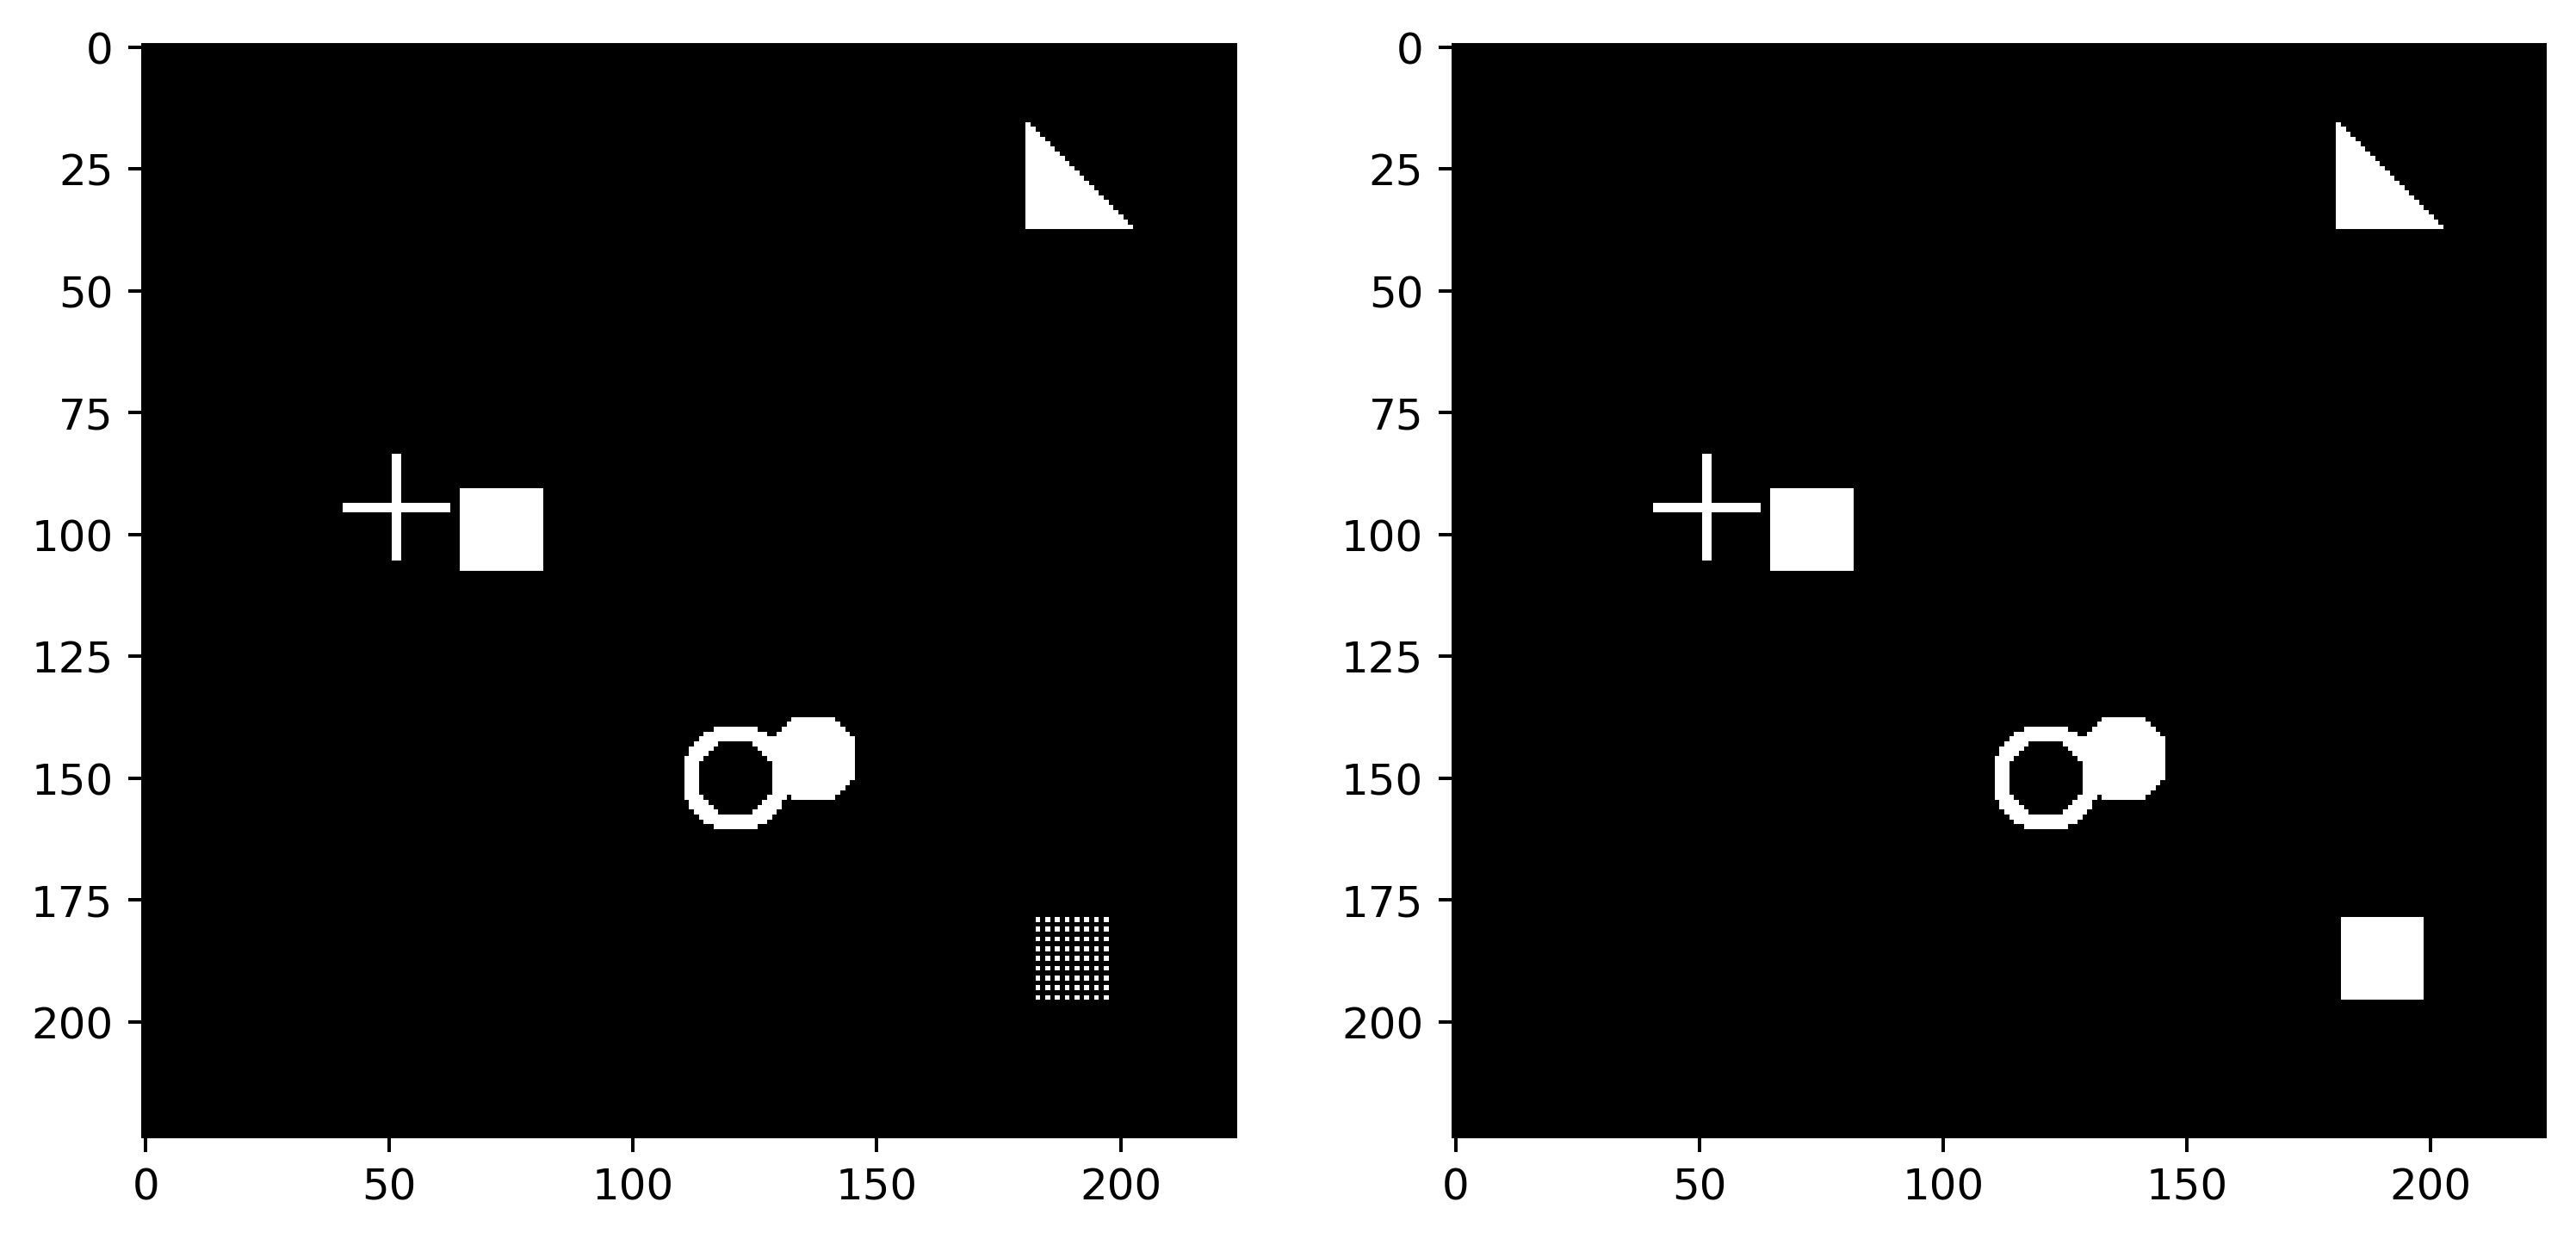

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 10), dpi=360)
ax[0].imshow(image.numpy()[0], cmap='gray')
ax[1].imshow(np.max(mask.numpy(), axis=0), cmap='gray')

## Нейронная сеть

### Encoder
![vggarc.png](images/vggarc.png)

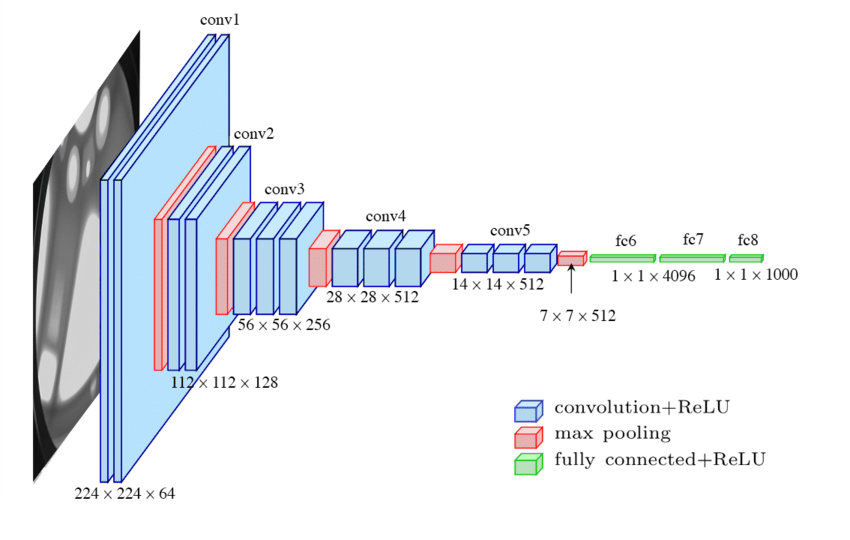

Conv2d:

![conv2d.png](images/conv2d.png)
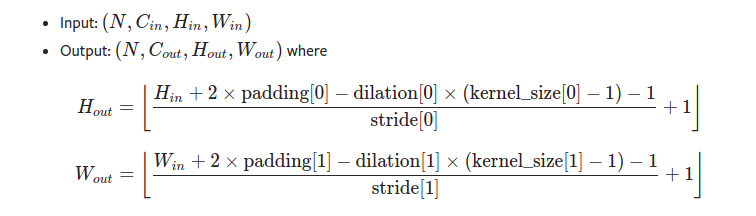

In [9]:
class VGGBlock(nn.Module):
    def __init__(self, in_channels=3, out_channels=64, 
                 conv_layers=2, batch_norm=True):
        super(VGGBlock, self).__init__()
        layers = []
        for i in range(conv_layers):
            layers.append(nn.Conv2d(in_channels, out_channels, 
                                    kernel_size=3, padding=1))
            in_channels = out_channels
            if batch_norm:
                layers.append(nn.BatchNorm2d(out_channels))
            layers.append(nn.ReLU())
        layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        self.block = nn.Sequential(*layers)
        
    def forward(self, x):
        x = self.block(x)
        return x

In [10]:
class VGG16(nn.Module):
    def __init__(self, batch_norm=True):
        super(VGG16, self).__init__()
        block_sequence = [
            VGGBlock(3, 64, 2, batch_norm),
            VGGBlock(64, 128, 2, batch_norm),
            VGGBlock(128, 256, 3, batch_norm),
            VGGBlock(256, 512, 3, batch_norm), 
            VGGBlock(512, 512, 3, batch_norm)
        ]
        self.block_sequence = nn.Sequential(*block_sequence)
    def forward(self, x):
        x = self.block_sequence(x)
        return x

### Full model
![encdec1.png](images/encdec1.png)

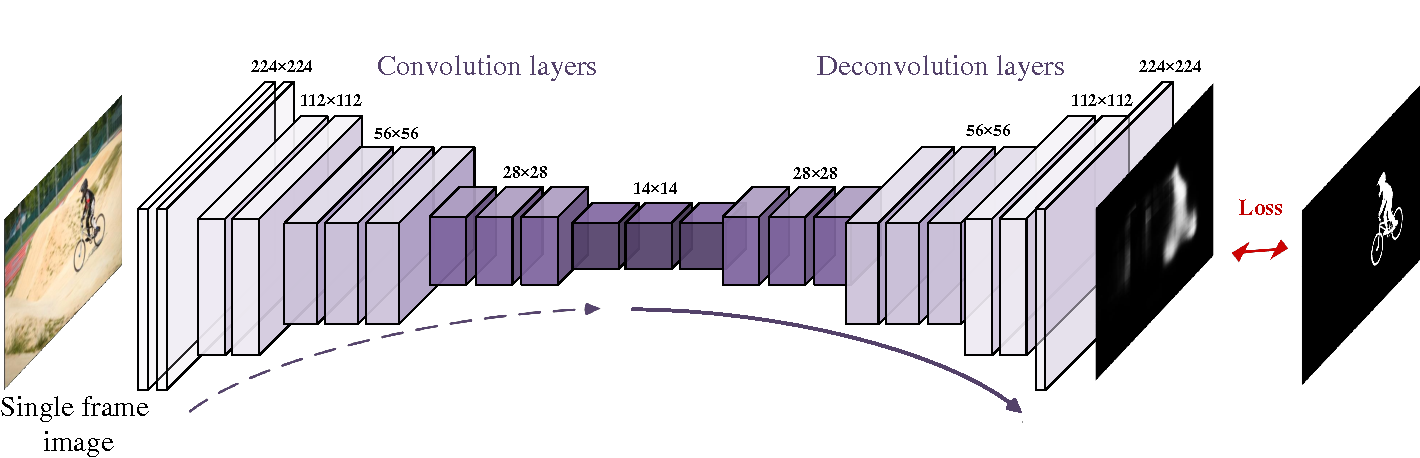

ConvTransposed2d:
![transposed.png](images/transposed.png)
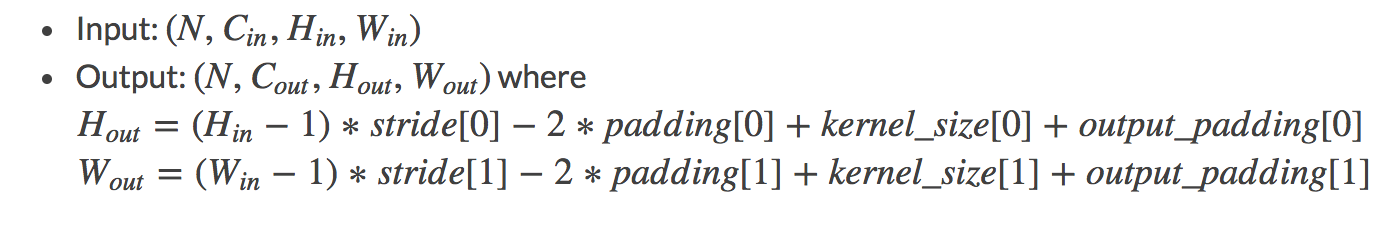

In [11]:
class FCN32(nn.Module):
    def __init__(self, encoder, n_class):
        super(FCN32, self).__init__()
        self.encoder = encoder
        self.relu = nn.ReLU()
        self.deconv1 = nn.ConvTranspose2d(512, 512, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.deconv2 = nn.ConvTranspose2d(512, 256, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.deconv3 = nn.ConvTranspose2d(256, 128, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.deconv4 = nn.ConvTranspose2d(128, 64, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.deconv5 = nn.ConvTranspose2d(64, 32, kernel_size=3,
                                         stride=2, padding=1, output_padding=1)
        self.classifier = nn.Conv2d(32, n_class, kernel_size=1)
        self.bn1 = nn.BatchNorm2d(512)
        self.bn2 = nn.BatchNorm2d(256)
        self.bn3 = nn.BatchNorm2d(128)
        self.bn4 = nn.BatchNorm2d(64)
        self.bn5 = nn.BatchNorm2d(32)
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.bn1(self.relu(self.deconv1(x)))
        x = self.bn2(self.relu(self.deconv2(x)))
        x = self.bn3(self.relu(self.deconv3(x)))
        x = self.bn4(self.relu(self.deconv4(x)))
        x = self.bn5(self.relu(self.deconv5(x)))
        x = self.classifier(x)
        return x

## Параметры

In [12]:
num_epoch = 50
batch_size = 20
lr = 1e-4
weight_decay = 1e-4

n_train = 2000
n_val = 500

n_class = 6
step_size = 50
gamma = 0.5

## Загрузчики данных

In [13]:
train_set = ShapeDataset(n_images=n_train, transforms=transforms)
val_set = ShapeDataset(n_images=n_val, transforms=transforms)
train_dataloder = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0)
val_dataloder = DataLoader(val_set, batch_size=batch_size, shuffle=False, num_workers=0)

## Модель

In [14]:
vgg16 = VGG16()
model = FCN32(encoder=vgg16, n_class=n_class)

## Функция потерь, оптимизатор, ...

In [15]:
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
scheduler = lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
print(device)

cuda:0


## Train & validation loops

In [16]:
def val(epoch, model):
    model.eval()
    model = model.to(device)
    with torch.no_grad():
        loss_stat = []
        for inputs, labels in val_dataloder:
            inputs = inputs.to(device)
            labels = labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss_stat.append(loss.cpu().item())
    print(f'Loss for epoch {epoch}: {np.mean(loss_stat)}')

In [17]:
def train(model):
    model = model.to(device)
    for epoch in tqdm(range(num_epoch)):
        model.train()
        for inputs, labels in train_dataloder:
            optimizer.zero_grad()
            inputs = inputs.to(device)
            labels = labels.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
        scheduler.step()
        val(epoch, model)
    torch.save(model.state_dict(), 'path_to_model.pth')

In [18]:
train(model)

  0%|          | 0/50 [00:00<?, ?it/s]

Loss for epoch 0: 0.6793909239768982
Loss for epoch 1: 0.6638440966606141
Loss for epoch 2: 0.6399565839767456
Loss for epoch 3: 0.6040031337738037
Loss for epoch 4: 0.5765371918678284
Loss for epoch 5: 0.5400376725196838
Loss for epoch 6: 0.4994170272350311
Loss for epoch 7: 0.45268000960350036
Loss for epoch 8: 0.41842111706733703
Loss for epoch 9: 0.37251933813095095
Loss for epoch 10: 0.33530086517333985
Loss for epoch 11: 0.2948849058151245
Loss for epoch 12: 0.26656723260879517
Loss for epoch 13: 0.23480583131313323
Loss for epoch 14: 0.2093218731880188
Loss for epoch 15: 0.1852516484260559
Loss for epoch 16: 0.16544595539569854
Loss for epoch 17: 0.147904372215271
Loss for epoch 18: 0.13224798679351807
Loss for epoch 19: 0.11664864063262939
Loss for epoch 20: 0.10509810537099838
Loss for epoch 21: 0.0949196097254753
Loss for epoch 22: 0.08462610751390458
Loss for epoch 23: 0.07646674126386642
Loss for epoch 24: 0.06955692738294601
Loss for epoch 25: 0.06396460682153701
Loss for 

In [ ]:
model.load_state_dict(torch.load('path_to_model.pth'))

In [26]:
inverse_transforms = Compose([Normalize((-0.485/0.229, -0.456/0.224, -0.406/0.225), 
                                        (1./0.229, 1./0.224, 1./0.225))])


/home/avarlamova/stuff/mmp_spring_2022/sem2/utils.py:223: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  plot_img_array(np.array(flatten_list), ncol=len(img_arrays))
/home/avarlamova/stuff/mmp_spring_2022/sem2/utils.py:223: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  plot_img_array(np.array(flatten_list), ncol=len(img_arrays))


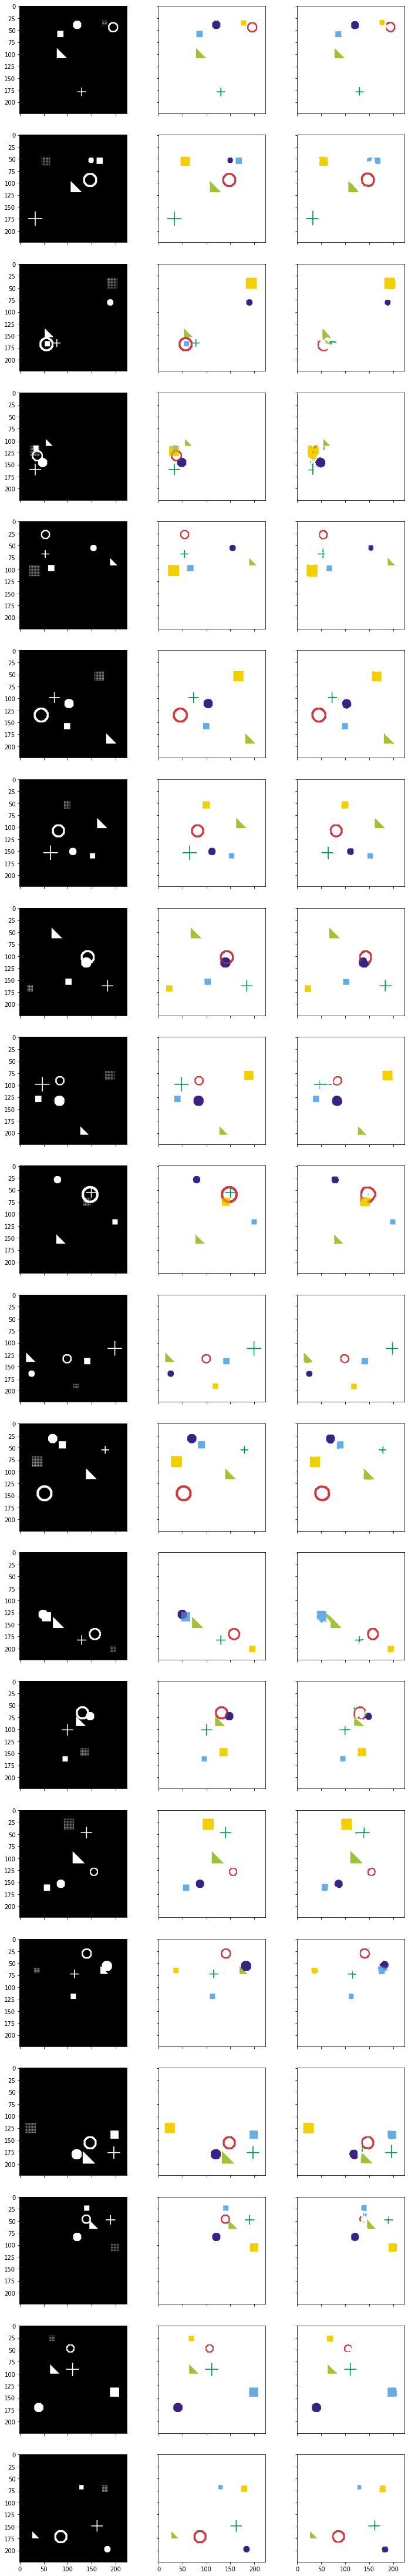

In [27]:
model.eval()   

inputs, labels = next(iter(val_dataloder))
inputs = inputs.to(device)
labels = labels.to(device)


pred = model(inputs)

pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()

input_images_rgb = [inverse_transforms(x).permute(1, 2, 0) for x in inputs.cpu()]

target_masks_rgb = [utils.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [utils.masks_to_colorimg(x) for x in pred]

utils.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])